<a href="https://www.kaggle.com/code/dmoyari/proyecto-inferencia?scriptVersionId=206420305" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Inicialización de librerías a utilizar e importación de la base de datos

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # Libreria para trabajar con algebra lineal
import pandas as pd # Libreria para el procesamiento de datos, estadigrafos y archivos csv data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px #Libreria para graficar
from sklearn.linear_model import Ridge #utilizamos la biblioteca de aprendisaje SKlearn e importamos la regreción Ridge
from sklearn.model_selection import train_test_split, GridSearchCV # Importamos herramientas de entrenamiento y busqueda
from sklearn.metrics import mean_squared_error, mean_absolute_error #Importamos herramientas de errores cuadrados y absolutos
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt #Librería para creación de gráficos 2D
import shap
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import ttest_1samp
import seaborn as sns
import matplotlib.pyplot as plt




# Input data files are available in the read-only "../input/" directory   
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'): #
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wec-perth-49-csv/WEC_Perth_49.csv


# Importación de la Base de datos y muestra de encabezado

In [2]:
df = pd.read_csv('/kaggle/input/wec-perth-49-csv/WEC_Perth_49.csv') #Importa la base de datos a la variable df desde la base de kaggle

df.head()  #muestra los valores que encabezan la base de datos

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,Power42,Power43,Power44,Power45,Power46,Power47,Power48,Power49,qW,Total_Power
0,600.0,0.0,546.16,37.50,489.79,74.88,432.47,112.05,650.0,0.0,...,88867.92,98844.30,101283.59,98934.63,101624.58,100915.03,99625.68,96704.34,0.87,4102461.43
1,593.0,12.0,546.16,37.50,489.79,74.88,432.47,112.05,644.0,8.0,...,88896.55,98759.79,101346.07,98873.59,101629.01,100934.53,99606.13,96718.39,0.87,4103361.41
2,593.0,12.0,546.16,37.50,489.79,74.88,432.47,112.05,644.0,8.0,...,88919.83,98746.68,101346.15,98875.57,101618.32,100941.00,99611.35,96719.14,0.87,4103680.44
3,593.0,12.0,546.16,37.50,489.79,74.88,432.47,112.05,644.0,8.0,...,88855.14,98760.96,101338.59,98971.58,101632.28,100943.59,99589.25,96735.04,0.87,4105661.06
4,200.0,0.0,146.17,37.53,89.76,74.93,32.40,112.18,400.0,0.0,...,88005.30,98630.24,100432.73,98803.01,101064.48,100948.38,99028.87,96286.71,0.79,3752648.77


# Muestra información de la cantidad de datos y entradas

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36043 entries, 0 to 36042
Columns: 149 entries, X1 to Total_Power
dtypes: float64(149)
memory usage: 41.0 MB


# Se realiza la limpieza de la base de datos

In [4]:

# Rellenar los valores faltantes mediante interpolación lineal

df_filled = df.interpolate(method='linear', limit_direction='forward', axis=0)


# se opta por la interpolación lineal para rellenar valores faltantes debido a la naturaleza continua de los datos, ya que permite una estimación razonable entre puntos adyacentes sin introducir sesgos.


# Detectar y eliminar outliers usando el método del rango intercuartílico (IQR)
Q1 = df_filled.quantile(0.25)
Q3 = df_filled.quantile(0.75)
IQR = Q3 - Q1

# Consideramos un valor outlier si está por debajo de Q1 - 1.5*IQR o por encima de Q3 + 1.5*IQR
# eliminamos los valores de outline y limpiamos la base de datos
df_cleaned = df_filled[~((df_filled < (Q1 - 1.5 * IQR)) | (df_filled > (Q3 + 1.5 * IQR))).any(axis=1)]

# Mostramos las primeras filas del dataframe después del procesamiento
df_cleaned.head()


# Utilizamos el método IQR (Rango intercuartil) porque es robusto y ayuda a identificar valores extremos sin suponer una distribución específica de los datos.

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,Power42,Power43,Power44,Power45,Power46,Power47,Power48,Power49,qW,Total_Power
8,800.0,0.0,746.17,37.53,689.76,74.93,632.4,112.18,1000.0,0.0,...,102533.55,101451.60,100040.55,98923.52,101203.83,100724.67,99030.73,96167.27,0.85,4037155.20
9,800.0,0.0,746.17,37.53,689.76,74.93,632.4,112.18,1000.0,0.0,...,102606.44,101172.01,99952.16,99128.99,101332.83,100801.06,99120.43,96611.90,0.86,4047144.20
90,550.0,0.0,700.00,50.00,1000.00,50.00,50.0,100.00,400.0,100.0,...,93967.33,89843.86,96327.82,99507.52,99856.80,100135.93,96431.15,96309.35,0.78,3703757.08
5425,0.0,0.0,200.00,0.00,300.00,100.00,550.0,0.00,700.0,100.0,...,93428.62,97945.71,97878.05,98461.06,102318.62,97312.62,96339.33,96555.54,0.80,3778118.48
5426,0.0,0.0,200.00,0.00,300.00,100.00,550.0,0.00,700.0,100.0,...,93452.68,97839.60,98100.51,98268.95,102333.41,97282.12,96352.51,96565.22,0.80,3782063.68


# Muestra información actual del contenido de la base de datos

In [5]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1281 entries, 8 to 35976
Columns: 149 entries, X1 to Total_Power
dtypes: float64(149)
memory usage: 1.5 MB


# Datos estadistico descriptivos

In [6]:
print(df_cleaned.describe()) #Se muestran los datos estadistico descriptivos

                X1      Y1           X2           Y2           X3  \
count  1281.000000  1281.0  1281.000000  1281.000000  1281.000000   
mean    515.495706     0.0   496.010055    33.020812   434.832834   
std     272.588733     0.0   230.287581    12.282551   224.292399   
min       0.000000     0.0     0.000000     0.000000    50.000000   
25%     200.000000     0.0   345.980000    37.420000   289.750000   
50%     600.000000     0.0   546.090000    37.520000   489.850000   
75%     800.000000     0.0   746.020000    37.540000   689.740000   
max     900.000000     0.0   850.000000    50.000000  1000.000000   

                Y3           X4           Y4           X5           Y5  ...  \
count  1281.000000  1281.000000  1281.000000  1281.000000  1281.000000  ...   
mean     74.613997   404.130429   103.955066   863.856362     9.172521  ...   
std       8.831391   208.533957    25.508777   191.644914    25.840903  ...   
min      50.000000    32.020000     0.000000   400.000000     

# Matriz de correlación y mapa de calor

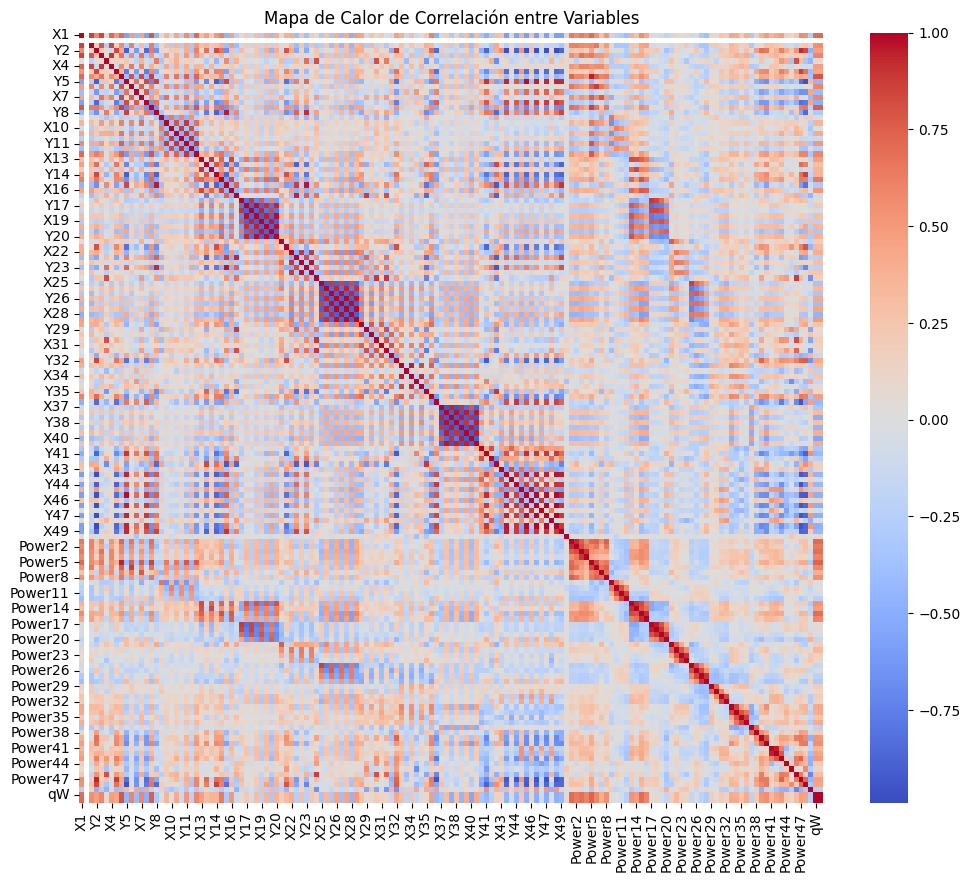

In [7]:
plt.figure(figsize=(12, 10))
correlation_matrix = df_cleaned.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Mapa de Calor de Correlación entre Variables')
plt.show()

# Variable de interes

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


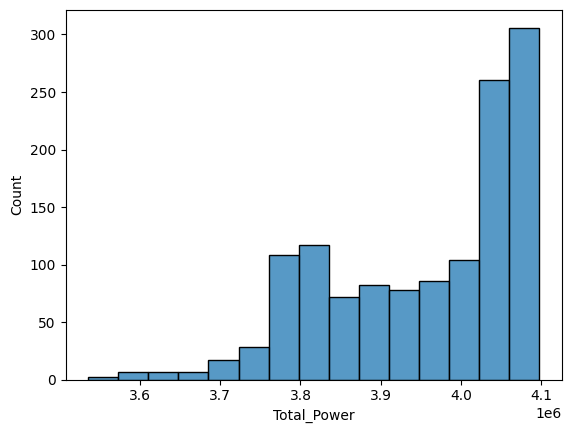

In [8]:
sns.histplot(df_cleaned['Total_Power'])
plt.show()

In [9]:
stat, p = shapiro(df_cleaned['Total_Power'])
print("Estadístico:", stat, "p-valor:", p)

Estadístico: 0.8753738035786287 p-valor: 8.290343518806184e-31


# Preparación y separación de datos

In [10]:
data = df_cleaned #importamos la base de datos limpia a la variable data

# utilizando data seleccionamos variables independientes y dependientes para prepararlas para la regresión de ridge

X = data.drop(columns=['Total_Power'])  
y = data['Total_Power']                 # le asignamos a Y el valor de la columna 'Total_Power' que sería la variable objetivo


# Dividimos las variables en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el escalador y ajustarlo al conjunto de entrenamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Transformar el conjunto de prueba usando el escalador ajustado
X_test_scaled = scaler.transform(X_test)

# Aplicación de regresión de ridge

In [11]:
# Definimos el modelo de Regresión Ridge
ridge = Ridge()

# Definimos los hiperparámetros a testear

param_grid = {'alpha': [0.1, 1.0, 10.0, 50.0, 100.0]}  # Ajusta estos valores según sea necesario

# Configurar GridSearchCV para encontrar el mejor alpha
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Usamos la herramienta best_ridge_model para buscar el mejor modelo
best_ridge_model = grid_search.best_estimator_
print(f'Mejor valor de alpha: {grid_search.best_params_["alpha"]}')


# Elegimos Ridge para este proyecto porque permite manejar la multicolinealidad en los datos mediante regularización L2, lo cual ayuda a mejorar la estabilidad del modelo.

Mejor valor de alpha: 100.0


# Realización de Predicciones y Evaluación del Rendimiento

# Boxplot para Total_Power

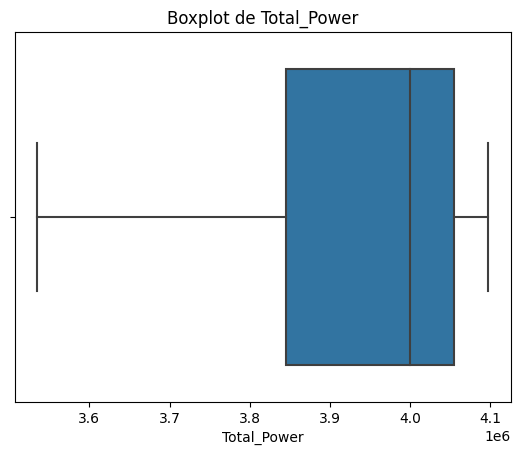

In [12]:
# Boxplot para Total_Power
sns.boxplot(x=df_cleaned['Total_Power'])
plt.title('Boxplot de Total_Power')
plt.show()

# Gráfico de predicción

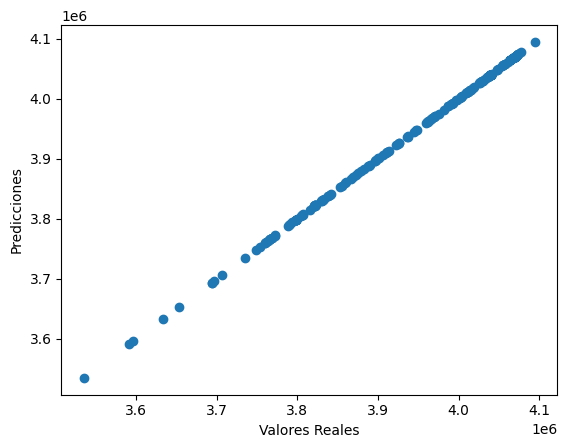

Intervalo de confianza del 95%: (3944357.1420866805, 3973544.0772469924)


In [13]:
# Predicción y visualización
y_pred = grid_search.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

# Intervalo de confianza para las predicciones
confidence_interval = stats.norm.interval(0.95, loc=np.mean(y_pred), scale=stats.sem(y_pred))
print("Intervalo de confianza del 95%:", confidence_interval)

In [14]:


# Realizar predicciones en el conjunto de prueba
y_pred = best_ridge_model.predict(X_test)

# Calcular las métricas de evaluación
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f'Error cuadratico medio: {rmse}')
print(f'Error absuluto medio: {mae}')

from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f'R²: {r2}')

Error cuadratico medio: 0.016248865737619227
Error absuluto medio: 0.009991938848019457
R²: 0.9999999999999813


# Gráfico de residuos

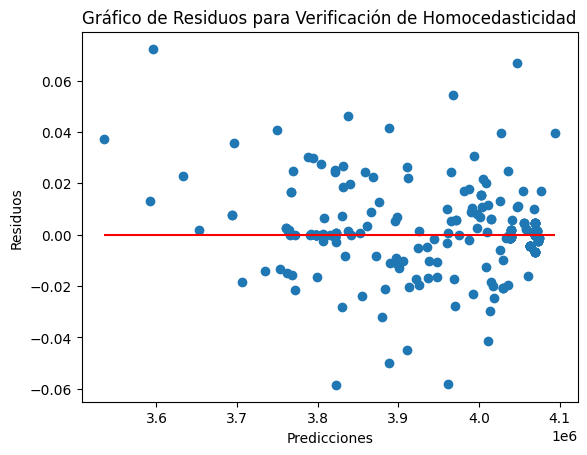

Estadístico t: 1.019787948430026
p-valor: 0.3087917980578718
No se rechaza la hipótesis nula: No hay evidencia de un sesgo en las predicciones.


In [15]:
# Gráfico de residuos para verificar homocedasticidad
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), colors='red')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos para Verificación de Homocedasticidad')
plt.show()

# Realizar la prueba de hipótesis
t_stat, p_value = ttest_1samp(residuals, 0)
print("Estadístico t:", t_stat)
print("p-valor:", p_value)


# Interpretación del resultado
if p_value < 0.05:
    print("Rechazamos la hipótesis nula: Existe evidencia de un sesgo en las predicciones.")
else:
    print("No se rechaza la hipótesis nula: No hay evidencia de un sesgo en las predicciones.")

# Evaluación de supuestos

In [16]:
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print("Estadístico de Durbin-Watson:", dw_stat)

# Interpretación del resultado
if 1.5 < dw_stat < 2.5:
    print("Los residuos son aproximadamente independientes.")
else:
    print("Existe autocorrelación en los residuos, lo que indica que los errores no son independientes.")

Estadístico de Durbin-Watson: 1.948304119249351
Los residuos son aproximadamente independientes.


# Análisis Inferencial sobre las Predicciones

In [17]:
# Obtener los coeficientes del modelo
feature_names = X.columns
coefficients = best_ridge_model.coef_

# Crear un DataFrame para una mejor visualización
coef_df = pd.DataFrame({'Variable': feature_names, 'Coeficiente': coefficients})
coef_df['Importancia_Absoluta'] = np.abs(coef_df['Coeficiente'])
coef_df = coef_df.sort_values(by='Importancia_Absoluta', ascending=False)

# Mostrar las variables más influyentes
print(coef_df.head(10))


# Resumen de análisis inferencial
print("Resumen del Análisis Inferencial:")
print(f"\n El intervalo de confianza del 95% para las predicciones es: {confidence_interval}")
if p_value < 0.05:
    print("La prueba de hipótesis mostró evidencia de sesgo en las predicciones (p < 0.05).")
else:
    print("La prueba de hipótesis no mostró evidencia significativa de sesgo en las predicciones (p > 0.05).")

    Variable  Coeficiente  Importancia_Absoluta
138  Power41     1.000008              1.000008
112  Power15     1.000004              1.000004
134  Power37     1.000003              1.000003
136  Power39     1.000003              1.000003
108  Power11     1.000002              1.000002
132  Power35     1.000002              1.000002
99    Power2     1.000002              1.000002
142  Power45     1.000002              1.000002
117  Power20     1.000001              1.000001
120  Power23     1.000001              1.000001
Resumen del Análisis Inferencial:

 El intervalo de confianza del 95% para las predicciones es: (3944357.1420866805, 3973544.0772469924)
La prueba de hipótesis no mostró evidencia significativa de sesgo en las predicciones (p > 0.05).


# Visualización de Importancia de Variables

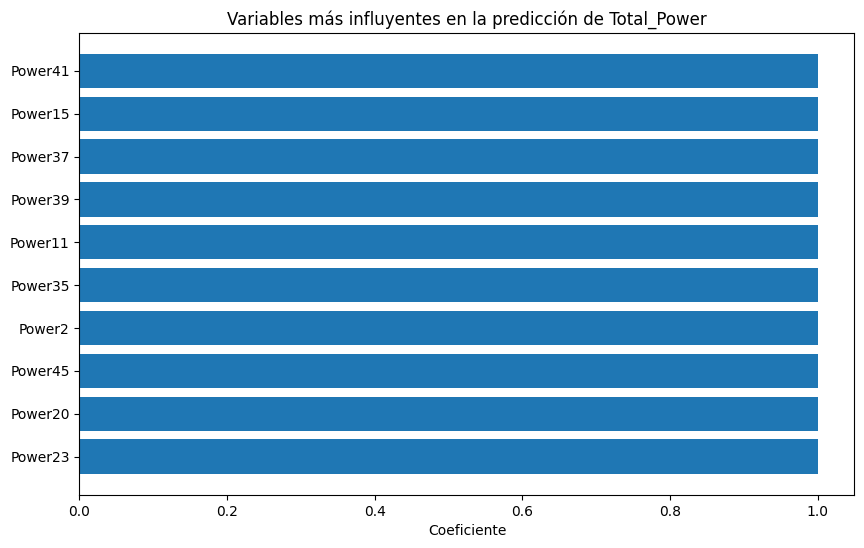

In [18]:
# Gráfica de los coeficientes
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Variable'].head(10), coef_df['Coeficiente'].head(10))
plt.xlabel('Coeficiente')
plt.title('Variables más influyentes en la predicción de Total_Power')
plt.gca().invert_yaxis()
plt.show()

# Interpretación del Modelo usando SHAP

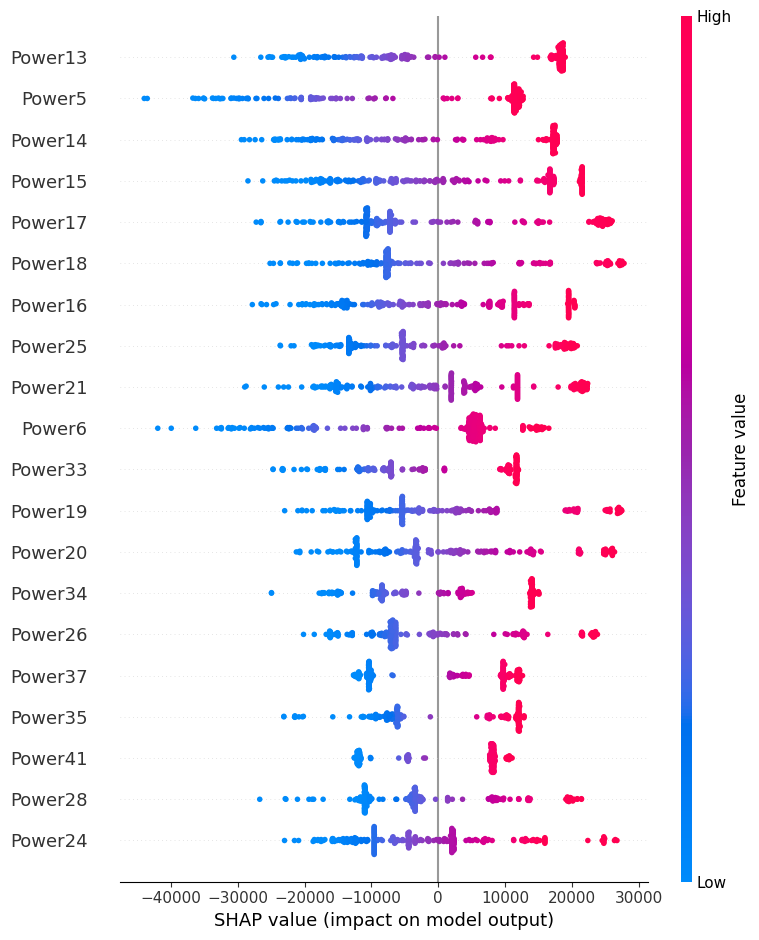

In [19]:

# Crear un explainer de SHAP
explainer = shap.LinearExplainer(best_ridge_model, X_train)
shap_values = explainer.shap_values(X_test)

# Visualización de SHAP para las variables más importantes
shap.summary_plot(shap_values, X_test, feature_names=X.columns)